Спутниковые снимки необходимы для широкого спектра применений, от борьбы со стихийными бедствиями и восстановления до сельского хозяйства и военной разведки. Однако облака представляют собой серьезную проблему во всех этих случаях использования и, как правило, должны быть идентифицированы и исключены из набора данных до использования спутниковых снимков. Совершенствование методов идентификации облаков может раскрыть потенциал для неограниченного числа приложений, использующих спутниковые снимки, что позволит проводить более быстрые, эффективные и точные исследования на основе изображений.

Целью данного проекта является обнаружение облачного покрова на спутниковых снимках, чтобы можно было устранить помехи от облаков. Используются общедоступные спутниковые данные от Sentinels-2, которые позволяют получать изображения с широким диапазоном, высоким разрешением и несколькими спектрами. Для каждого изображения данные разделены на различные полосы света, охватывающие весь видимый спектр, а также ближнюю и инфракрасную области спектра. 

В процессе исследования будет изучено:
- изучение данных
- подготовка данных
- написание кода
- построение модели
- подгонка модели
- подготовка итогово кода проекта

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_path import path
from pathlib import Path
from PIL import Image
import pytorch_lightning as pl
import torch

ИЗУЧЕНИЕ ДАННЫХ

Сначала загрузим все данные

Обучающие данные состоят из "фишек". Каждая фишка представляет собой изображение определенной местности, снятое в определенный момент времени. С каждой фишкой связано по четыре изображения. 

In [31]:
DATA_DIR = Path.cwd().parent.resolve() / "E:/1/projects/jobs/cloud-cover-predict/data"
TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"

assert TRAIN_FEATURES.exists()

Каждое изображение в "фишке" содержит фото в различном диапазоне длин волн, или еще называют "band". Например, band B02 для каждой фишки показывает интенсивность видимого синего света, длина волны которого составляет около 492 нанометров (нм). Список band'ов представлен ниже:

B02 	Blue visible light 	    497 nm;<br>
B03 	Green visible light 	560 nm;<br>
B04 	Red visible light 	    665 nm;<br>
B08 	Near infrared light 	835 nm.

Зададим глобальную переменную со списком band в обучающих данных, чтобы было проще проводить по ним итерацию.

In [32]:
BANDS = ["B02", "B03", "B04", "B08"]

Метаданные

Посмотрим из каких колонок состоит обучающий набор данных.

In [33]:
train_meta = pd.read_csv(DATA_DIR / "train_metadata.csv")
train_meta.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj


In [34]:
# выведем информацию, сколько "фишек" с уникальным ID, мест проведения съемки и врменного интервала 
train_meta[["chip_id", "location", "datetime"]].nunique()

chip_id     32
location     6
datetime     6
dtype: int64

Распределение "фишек" по местоположению

In [35]:
train_location_counts = (
    train_meta.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

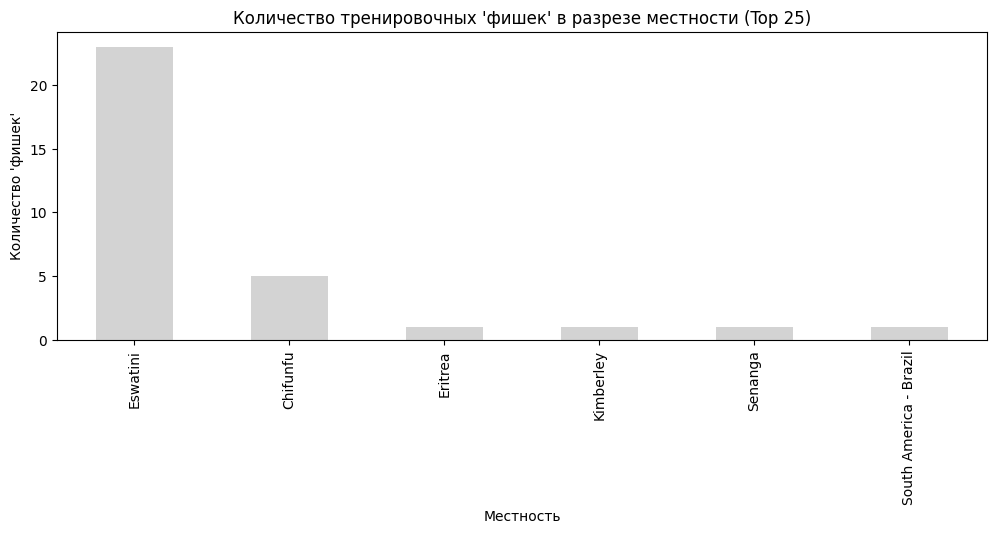

In [38]:
plt.figure(figsize=(12, 4))
train_location_counts.head(25).plot(kind="bar", color="lightgray")
plt.xticks(rotation=90)
plt.xlabel("Местоположение")
plt.ylabel("Количество 'фишек'")
plt.title("Количество тренировочных 'фишек' в разрезе местоположения (Top 25)")
plt.show()

Выведем временные метки для каждой "фишки". Сгруппируем данные по годам.

In [39]:
train_meta["datetime"] = pd.to_datetime(train_meta["datetime"])
train_meta["year"] = train_meta.datetime.dt.year
train_meta.groupby("year")[["chip_id"]].nunique().sort_index().rename(
    columns={"chip_id": "chip_count"}
)

,chip_count
year,
2019,1
2020,31


Самая первая и крайняя последнняя даты в представленном наборе данных

In [40]:
train_meta["datetime"].min(), train_meta["datetime"].max()

(Timestamp('2019-12-17 08:44:40+0000', tz='UTC'),
 Timestamp('2020-09-12 07:57:18+0000', tz='UTC'))

Сгруппируем данные по местоположению

In [41]:
chips_per_locationtime = (
    train_meta.groupby(["location", "datetime"])[["chip_id"]]
    .nunique()
    .sort_values(by="chip_id", ascending=False)
    .rename(columns={"chip_id": "chip_count"})
)
chips_per_locationtime.head(10)

,,chip_count
location,datetime,
Eswatini,2020-09-12 07:57:18+00:00,23
Chifunfu,2020-04-29 08:20:47+00:00,5
Eritrea,2020-09-03 08:05:42+00:00,1
Kimberley,2020-09-06 08:28:30+00:00,1
Senanga,2019-12-17 08:44:40+00:00,1
South America - Brazil,2020-09-06 15:02:37+00:00,1


Все изображения в данных были сделаны в период с февраля 2018 по сентябрь 2020 года. Из данных обучения мы также можем видеть, что многие "фишки" сфотографированы в одном и том же месте и в одно и то же время.

Изображения

Теперь исследуем спутниковые снимки.

Для удобства давайте сначала добавим пути ко всем изображениям объектов в каждой "фишке" . Напомним, что в папке для каждого "фишки" есть четыре изображения, каждое из которых соответствует своему диапазону длин световой волны.